# Train a model with Classical Training

Although episodic training has attracted a lot of interest in the early years of Few-Shot Learning research, more recent works suggest that competitive results can be achieved with a simple cross entropy loss across all training classes. Therefore, it is becoming more and more common to use this classical process to train the backbone, that will be common to all methods compared at test time.

This is in fact more representative of real use cases: episodic training assumes that, at training time, you have access to the shape of the few-shot tasks that will be encountered at test time (indeed you choose a specific number of ways for episodic training). You also "force" your inference method into the training of the network. Switching the few-shot learning logic to inference (i.e. no episodic training) allows methods to be agnostic of the backbone.

Nonetheless, if you need to perform episodic training, we also provide [an example notebook](episodic_training.ipynb) for that.

## Getting started
First we're going to do some imports (this is not the interesting part).

In [1]:
try:
    import google.colab
    colab = True
except:
    colab = False

In [2]:
if colab is True:
    # Running in Google Colab
    # Clone the repo
    !git clone https://github.com/sicara/easy-few-shot-learning
    %cd easy-few-shot-learning
    !pip install .
else:
    # Run locally
    # Ensure working directory is the project's root
    # Make sure easyfsl is installed!
    %cd ..

Cloning into 'easy-few-shot-learning'...
remote: Enumerating objects: 837, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 837 (delta 171), reused 181 (delta 130), pack-reused 539
Receiving objects: 100% (837/837), 2.21 MiB | 24.92 MiB/s, done.
Resolving deltas: 100% (461/461), done.
/content/easy-few-shot-learning
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/easy-few-shot-learning
  Preparing metadata (setup.py) ... done
  Created wheel for easyfsl: filename=easyfsl-1.1.0-py3-none-any.whl size=45218 sha256=71dfbb4b187288e25608922f27feb2878d556b67b5c3c3c30cd03e720a955288
  Stored in directory: /root/.cache/pip/wheels/54/29/db/7eee3a758434d4337d8e4b1058b4b8cf2b33174f7f34da3ee9
Successfully built easyfsl


In [3]:
from pathlib import Path
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm

Then we're gonna do the most important thing in Machine Learning research: ensuring reproducibility by setting the random seed. We're going to set the seed for all random packages that we could possibly use, plus some other stuff to make CUDA deterministic (see [here](https://pytorch.org/docs/stable/notes/randomness.html)).

I strongly encourage that you do this in **all your scripts**.

In [4]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Then we're gonna create our data loader for the training set. You can see that I chose tu use CUB in this notebook, because it’s a small dataset, so we can have good results quite quickly. I set a batch size of 128 but feel free to adapt it to your constraints.

Note that we're not using the `TaskSampler` for the train data loader, because we won't be sampling training data in the shape of tasks as we would have in episodic training. We do it **normally**.

In [5]:
# Download the CUB dataset
!bash scripts/download_CUB.sh

Streaming output truncated to the last 5000 lines.
images/167.Hooded_Warbler/Hooded_Warbler_0024_2654633686.jpg
images/167.Hooded_Warbler/Hooded_Warbler_0025_2690306769.jpg
images/167.Hooded_Warbler/Hooded_Warbler_0026_2817738193.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0001_495149583.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0002_2471636465.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0003_2540117270.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0004_2301685839.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0005_498814033.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0006_2519317376.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0007_2468962218.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0008_2464457843.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0009_2591413864.jpg
images/166.Golden_winged_Warbler/Golden_winged_Warbler_0010_2316599673.jpg
images/166.Golden_

In [6]:
from easyfsl.datasets import CUB
from torch.utils.data import DataLoader

batch_size = 128
n_workers = 12

train_set = CUB(split="train", training=True)
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    num_workers=n_workers,
    pin_memory=True,
    shuffle=True,
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Now, we are going to create the model that we want to train. Here we choose the ResNet12 that is very often used in Few-Shot Learning research. Note that the default setting of these networks in EasyFSL is to not have a last fully connected layer (as it is usual for most Few-Shot Learning methods), but for classical training we need this layer! We also force it to output a vector which size is the number of different classes in the training set.

In [7]:
from easyfsl.modules import resnet12

DEVICE = "cuda"

# model is just straight up a resnet 12, trained on a classification task with 140 classes
model = resnet12(
    use_fc=True,
    num_classes=len(set(train_set.get_labels())),
).to(DEVICE)

In [43]:
# how does the model look like
model # it has the final last layer actually for the 140 classes (used for training!)
# validation and test have other classes, overall there are 200
# note how the activation of the last layer is linear, not softmax!

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(

Now, we still need validation ! Since we're training a model to perform few-shot classification, we will validate on few-shot tasks, so now we'll use the `TaskSampler`. We arbitrarily set the shape of the validation tasks. Ideally, you'd like to perform validation on various shapes of tasks, but we didn't implement this yet (feel free to contribute!).

We also need to define the few-shot classification method that we will use during validation of the neural network we're training.
Here we choose Prototypical Networks, because it's simple and efficient, but this is still an arbitrary choice.

In [ ]:
# again, in a few shot learning setting the classes of training, validation and test are disjoint
# aka, we validate and test on completely new classes that were never used for training

In [8]:
from easyfsl.methods import PrototypicalNetworks
from easyfsl.samplers import TaskSampler

n_way = 5
n_shot = 5
n_query = 10
n_validation_tasks = 500

val_set = CUB(split="val", training=False)
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

# the model is itself is just a regular resnet12! but then it gets embedded into 
# this few-shot-classifier class and can then be used for few-shot classification!
few_shot_classifier = PrototypicalNetworks(model).to(DEVICE)

In [9]:
xb, yb = next(iter(train_loader))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
xb.shape, yb.shape # batch of 128, 84x84x3 images, yb is of course labels

(torch.Size([128, 3, 84, 84]), torch.Size([128]))

In [19]:
yb

tensor([120,  83,  28, 107,  15, 109, 119,  25, 105,  84,  93,  81,  46,  20,
          9,   4, 117, 118,  92,  34,  55,  35, 120,  93,  74,  24, 129,  89,
         69,  35,  27,  28,   1,  54,  99, 109,   6,  97, 127,  57,  93,  70,
          8,  62,  34,  86,  24,  73,   6,  95,  99,  42,  22,  20,  79, 138,
        133,   2,  99, 133, 136,  19, 129, 116,   1,  83,  67, 124,  24,  58,
         32,  90, 116,  53,   2, 108,  13, 118, 125, 129, 108, 137,  97,  24,
         39,  20, 137, 110, 116,  51,  76, 133,  49,  96,  81, 104, 139,   7,
         34,  45,  18, 112,  31, 109,  52, 136,  73,  88,  24,  84,  19,  78,
        122,  57,  64,  74,  25,  74,  38,  65, 132, 109, 123,  82,  22,  17,
         24, 119])

In [16]:
img_tensor = xb[0]


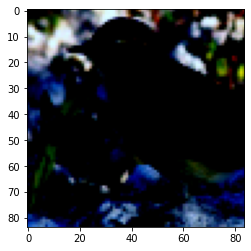

In [17]:
import matplotlib.pyplot as plt
img_tensor = torch.einsum("chw->hwc", img_tensor)
plt.imshow(img_tensor)

In [33]:
val_batch = next(iter(val_loader)) # a 5 way, 5 shot task with 10 query images, overall 500 tasks
val_batch

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[tensor([[[[ 1.9064,  1.3242, -0.8849,  ...,  1.7523,  1.7694,  1.7523],
           [ 1.9064,  1.8722,  0.6906,  ...,  1.7523,  1.7523,  1.7352],
           [ 1.9407,  1.9064,  1.8037,  ...,  1.7523,  1.7352,  1.7523],
           ...,
           [ 1.8893,  1.8722,  1.8722,  ...,  1.6495,  1.6153,  1.4783],
           [ 1.8722,  1.8722,  1.8893,  ...,  1.6667,  1.6153,  1.5297],
           [ 1.8722,  1.8722,  1.8893,  ...,  1.6667,  1.6153,  1.5468]],
 
          [[ 2.1660,  1.6933, -0.3725,  ...,  2.0609,  2.0609,  2.0434],
           [ 2.1660,  2.1485,  1.1681,  ...,  2.0609,  2.0434,  2.0434],
           [ 2.1660,  2.1835,  2.0959,  ...,  2.0434,  2.0434,  2.0259],
           ...,
           [ 2.1485,  2.1310,  2.1485,  ...,  2.0259,  2.0084,  1.8859],
           [ 2.1485,  2.1485,  2.1485,  ...,  2.0434,  2.0084,  1.9559],
           [ 2.1485,  2.1485,  2.1485,  ...,  2.0434,  1.9909,  1.9384]],
 
          [[ 2.6051,  2.1171, -0.0267,  ...,  2.6051,  2.6051,  2.6051],
           [ 

In [34]:
a, b, c, d, e = val_batch

# a, b are samples, labels of 5 way 5 shot, i.e. 5 images from 5 classes, randomly sampled, which represents the support set
# c, d are samples, labels of the 10 support images per same 5 classes, (each class has 10 images sampled), which represents the query set

In [25]:
a.shape # 5 way 5 shot, this represents the support set (5 images from 5 classes randomly sampled)

torch.Size([25, 3, 84, 84])

In [35]:
b  # the 5 samples of 5 classes

tensor([2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 1, 1, 1, 1,
        1])

In [36]:
c.shape, d

(torch.Size([50, 3, 84, 84]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]))

In [37]:
e  # the mapping to global classes, I suppose

[0, 8, 13, 21, 24]

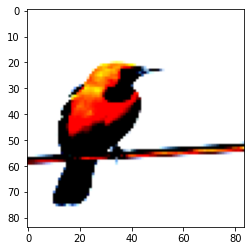

In [38]:
img_tensor_support = torch.einsum("chw->hwc", c[0])
plt.imshow(img_tensor_support)

In [45]:
# model actually outputs a softmax layer for classes  # non-normalized logits
yp = model.forward(xb.to(DEVICE))

In [46]:
yp

tensor([[-0.1085, -0.6527, -0.4224,  ...,  0.3266, -0.2724,  0.6026],
        [-0.7975, -1.5540, -1.3912,  ...,  0.2414, -0.4682,  1.0169],
        [-0.4201, -1.0728, -0.9799,  ..., -0.2663, -0.9227,  0.5433],
        ...,
        [ 1.1069,  1.5226,  0.0427,  ..., -1.7281,  0.9579, -2.0080],
        [ 0.6613,  0.0227,  0.4233,  ..., -0.1401, -0.4786, -0.1194],
        [-1.1830, -1.1983, -1.8777,  ...,  1.8082,  0.5372,  1.6366]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

## Training

Now let's define our training helpers ! I chose to use Stochastic Gradient Descent on 200 epochs with a scheduler that divides the learning rate by 10 after 120 and 160 epochs. The strategy is derived from [this repo](https://github.com/fiveai/on-episodes-fsl).

We're also gonna use a TensorBoard because it's always good to see what your training curves look like.

An other thing: we're doing 200 epochs like in [the episodic training notebook](notebooks/episodic_training.ipynb), but keep in mind that an epoch in classical training means one pass through the 6000 images of the dataset, while in episodic training it's an arbitrary number of episodes. In the episodic training notebook an epoch is 500 episodes of 5-way, 5-shot, 10-query tasks, so 37500 images. TL;DR you may want to monitor your training and increase the number of epochs if necessary.

In [47]:
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

# n_epochs = 200
n_epochs = 10
# scheduler_milestones = [150, 180]
scheduler_milestones = [5, 8]
scheduler_gamma = 0.1
learning_rate = 1e-01
tb_logs_dir = Path(".")

# model trained on stochastic gradient descent on CrossEntropy
train_optimizer = SGD(
    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

And now let's get to it! Here we define the function that performs a training epoch.

We use tqdm to monitor the training in real time in our logs.

In [48]:
def training_epoch(model_: nn.Module, data_loader: DataLoader, optimizer: Optimizer):
    all_loss = []
    model_.train()
    with tqdm(data_loader, total=len(data_loader), desc="Training") as tqdm_train:
        for images, labels in tqdm_train:
            optimizer.zero_grad()

            loss = LOSS_FUNCTION(model_(images.to(DEVICE)), labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

And we have everything we need! This is now the time to **start training**.

A few notes:

- We only validate every 10 epochs (you may set an even less frequent validation) because a training epoch is much faster than 500 few-shot tasks, and we don't want validation to be the bottleneck of our training process.

- I also added something to log the state of the model that gave the best performance on the validation set.

In [49]:
from easyfsl.methods.utils import evaluate


best_state = model.state_dict()
best_validation_accuracy = 0.0
validation_frequency = 10
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(model, train_loader, train_optimizer)

    if epoch % validation_frequency == validation_frequency - 1:

        # We use this very convenient method from EasyFSL's ResNet to specify
        # that the model shouldn't use its last fully connected layer during validation.

        # what does model look like if set_use_fc(False)?
        model.set_use_fc(False)
        validation_accuracy = evaluate(
            few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
        )

        # evaluate calls process_support_image, which in turn is just a backbone.forward
        # so it looks like the model is trained on a classic classification task,
        # but then it only uses the backbone to compute the vector of embeddings,
        # and then from the embedding vector the prototypes are computed using 
        # a custom function
        model.set_use_fc(True)

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_state = model.state_dict()
            print("Ding ding ding! We found a new best model!")

        tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    tb_writer.add_scalar("Train/loss", average_loss, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

Epoch 0


Training:   0%|          | 0/34 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training: 100%|██████████| 34/34 [00:36<00:00,  1.07s/it, loss=4.71]


Epoch 1


Training: 100%|██████████| 34/34 [00:35<00:00,  1.03s/it, loss=4.65]


Epoch 2


Training: 100%|██████████| 34/34 [00:37<00:00,  1.09s/it, loss=4.58]


Epoch 3


Training: 100%|██████████| 34/34 [00:37<00:00,  1.10s/it, loss=4.52]


Epoch 4


Training: 100%|██████████| 34/34 [00:36<00:00,  1.06s/it, loss=4.52]


Epoch 5


Training: 100%|██████████| 34/34 [00:36<00:00,  1.08s/it, loss=4.41]


Epoch 6


Training: 100%|██████████| 34/34 [00:37<00:00,  1.11s/it, loss=4.36]


Epoch 7


Training: 100%|██████████| 34/34 [00:37<00:00,  1.12s/it, loss=4.3]


Epoch 8


Training: 100%|██████████| 34/34 [00:36<00:00,  1.08s/it, loss=4.31]


Epoch 9


Validation: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s, accuracy=0.472]

Ding ding ding! We found a new best model!


Yay we successfully performed Classical Training! Now if you want to you can retrieve the best model's state.

In [51]:
# model.backbone. # does not exist

AttributeError: ignored

In [50]:
model.load_state_dict(best_state)

<All keys matched successfully>

## Evaluation

Now that our model is trained, we want to test it.

First step: we fetch the test data. Note that we'll evaluate on the same shape of tasks as in validation. This is malicious practice, because it means that we used *a priori* information about the evaluation tasks during training. This is still less malicious than episodic training, though.

In [52]:
n_test_tasks = 1000

test_set = CUB(split="test", training=False)
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Second step: we instantiate a few-shot classifier using our trained ResNet as backbone, and run it on the test data. We keep using Prototypical Networks for consistence, but at this point you could basically use any few-shot classifier that takes no additional trainable parameters.

Like we did during validation, we need to tell our ResNet to not use its last fully connected layer.

In [58]:
model.set_use_fc(False)

yp_no_fc = model.forward(xb.to(DEVICE))
yp_no_fc.shape # with set_use_fc(False) the model returns the 640D embedding vector!

torch.Size([128, 640])

In [59]:
model.set_use_fc(True)

yp_with_fc = model.forward(xb.to(DEVICE))
yp_with_fc.shape # with set_use_fc(True) the model returns the 140 logits used for classification

torch.Size([128, 140])

In [ ]:
model.set_use_fc(False)

# will sample random 1000 5 way 5 shot FSL tasks, each with 5 support images and 10 query images from 5 different classes
# note how this does not use the model, but few_shot_classifier. This is an instantiation of the 
# trained model as a few-shot classifier object, which has access to methods and functions for 
# FSL tasks!
# since we only trained for 10 epochs the accuracy is gonna be shit, naturally
accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 73%|███████▎  | 729/1000 [05:14<00:58,  4.64it/s, accuracy=0.391]